In [1]:
#making the necessary imports
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from gensim.models import Word2Vec
import numpy as np
import random
from tqdm import tqdm
import umap

 
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Combining the movies and the ratings file based on movieId. For Simplicity Lets take 10% of the data.
ratings = pd.read_csv('ratings.csv')
ratings = ratings.sample(frac=0.1)
movies = pd.read_csv('movies.csv')
data=pd.merge(ratings,movies,how="inner")
data.to_csv('data.csv',index=False)

In [3]:
#converting the 'movieId' column to type-String
#Collecting a list of all userId's in variable- users
data['movieId']= data['movieId'].astype(str)
users = ratings["userId"].unique().tolist()

In [4]:
'''
Consider one user at a time and sort the ratings based on timestamp. Assuming this is the sequence 
in which the user watched the movies, create a sequence of user watch history based on window size.

For e.g., Consider the user has rated (watched) the movies in the following order : 100, 1 , 7, 3 ,500 , 22.
Window size is 5.

Problem formulation: Based on user's watch history, which is the most likely movie that should be recommended

Here for LSTM,
X=[100,1,7,3,500]
y=[22]

Following is the code to prepare X so that it can be later used to create embeddings using word2vec. Consequently, we will
create y as well.

'''
y=[]
windowSize=5
X=[]
for usr in tqdm(users):
  tempUserData=data[data['userId'] == usr]
  tempUserData=tempUserData.sort_values('timestamp').reset_index()
  for i in range(len(tempUserData)-windowSize):
    fx=[]
    for j in range(windowSize):
      fx.append(tempUserData.iloc[i+j].movieId)
    i=i+windowSize
    X.append(fx)
    y.append(tempUserData.iloc[i].movieId)

100%|██████████| 5966/5966 [00:50<00:00, 118.08it/s]


In [5]:
#Passing our X to the Word2Vec model to create embeddings for each movieId
Word2VecModel = Word2Vec(window = 5, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

Word2VecModel.build_vocab(X, progress_per=200)

Word2VecModel.train(X, total_examples = Word2VecModel.corpus_count, 
            epochs=10, report_delay=1)

(3679390, 3681400)

C:\Users\jayes\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


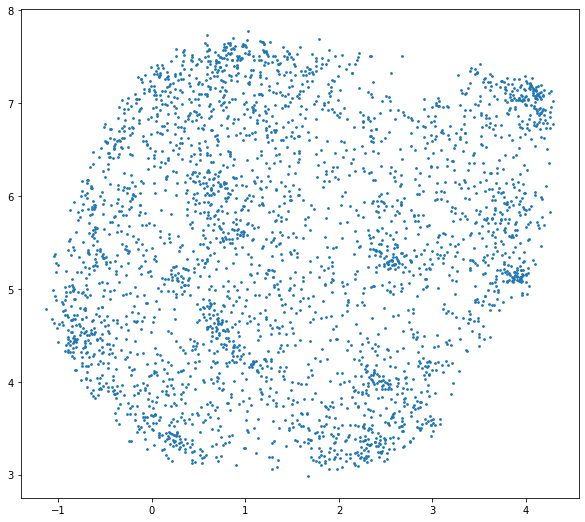

In [6]:
#Visualize the word embeddings and the clusters
voc=Word2VecModel[Word2VecModel.wv.vocab]
clusterEmb = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(voc)

plt.figure(figsize=(10,9))
plt.scatter(clusterEmb[:, 0], clusterEmb[:, 1], s=3, cmap='Spectral')

In [7]:
'''
LSTM accepts the input in the following format. 
X=[[
    [embedding of movie- 100],
    [embedding of movie- 1],
    [embedding of movie- 7],
    [embedding of movie- 3],
    [embedding of movie- 500]
]]

Converting our sequence of watched movies into their embeddings and preparing X in the above format.
Also converting our y to one-hot vector
'''
vocab = Word2VecModel.wv.vocab
finalX=[]
preFinaly=[]
for i,j in tqdm(zip(X,y)):
  tempList=[]
  flag=False
  for j in i:
    if(j not in vocab):
      flag=True
      break
    tempList.append(Word2VecModel[j])
  if(flag):
    continue
  else:
    finalX.append(tempList)
    preFinaly.append(j)
ycat = to_categorical(preFinaly, num_classes=3953)
finalX=np.array(finalX,dtype=np.float32)
finalY=np.array(ycat,dtype=np.float32)

0it [00:00, ?it/s]C:\Users\jayes\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
73628it [00:01, 48441.70it/s]


In [8]:
#Train-test Split

X_train, X_test, y_train, y_test = train_test_split(finalX, finalY, test_size=0.33, random_state=42)

In [9]:
#Building the model
model=Sequential()
model.add(LSTM(128, dropout=0.2))
model.add(Dense(3953,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [10]:
#Training and Validation
model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
1538/1538 [==============================] - 19s 11ms/step - loss: 7.2819 - accuracy: 0.0664 - val_loss: 5.2870 - val_accuracy: 0.4203
Epoch 2/10
1538/1538 [==============================] - 15s 10ms/step - loss: 4.9936 - accuracy: 0.4449 - val_loss: 3.9826 - val_accuracy: 0.5796
Epoch 3/10
1538/1538 [==============================] - 13s 9ms/step - loss: 4.1127 - accuracy: 0.5578 - val_loss: 3.6618 - val_accuracy: 0.6040
Epoch 4/10
1538/1538 [==============================] - 15s 10ms/step - loss: 3.8188 - accuracy: 0.5887 - val_loss: 3.6174 - val_accuracy: 0.6159
Epoch 5/10
1538/1538 [==============================] - 19s 13ms/step - loss: 3.8456 - accuracy: 0.5956 - val_loss: 3.6643 - val_accuracy: 0.6200
Epoch 6/10
1538/1538 [==============================] - 19s 12ms/step - loss: 3.9298 - accuracy: 0.5963 - val_loss: 3.7306 - val_accuracy: 0.6235
Epoch 7/10
1538/1538 [==============================] - 19s 12ms/step - loss: 3.9736 - accuracy: 0.5978 - val_loss: 3.7843 - 

In [11]:
#Saving the LSTM model
model.save('finalLSTMModel.h5')

In [ ]:
import pickle
filename = 'Word2VecModel.pkl'
pickle.dump(Word2VecModel, open(filename, 'wb'))